In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
pd.set_option('mode.chained_assignment', None)
import geopandas as gpd

In [69]:
df = pd.read_csv("/media/rghoshal/D4A6E10AA6E0EE441/UGP/datasets/data.csv",index_col = 0)

In [70]:
# Oceanic divide
time = pd.DatetimeIndex(df["time"].unique())
indian_ocean = df[(df["lat"] < 8) & (df["sla"].isnull() == False)]
arabian_sea = df[(df["lat"] > 8) & (df["lon"] < 77.5) & (df["sla"].isnull() == False)]
bay_bangal = df[(df["lat"] > 8) & (df["lon"] > 77.5) & (df["sla"].isnull() == False)]

s1 = indian_ocean["sla"].groupby(pd.DatetimeIndex(indian_ocean['time'])).mean()
s2 = arabian_sea["sla"].groupby(pd.DatetimeIndex(arabian_sea['time'])).mean()
s3 = bay_bangal["sla"].groupby(pd.DatetimeIndex(bay_bangal['time'])).mean()

In [71]:
# Land Divide

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))
region1 = gpd.read_file('region1.geojson')
region2 = gpd.read_file('region2.geojson')
region3 = gpd.read_file('region3.geojson')
region4 = gpd.read_file('region4.geojson')

In [72]:
mask_region1 = (region1.loc[0, 'geometry'])
mask_region2 = (region2.loc[0, 'geometry'])
mask_region3 = (region3.loc[0, 'geometry'])
mask_region4 = (region4.loc[0, 'geometry'])
gdf.loc[:,'region1'] = gdf.within(mask_region1)
gdf.loc[:,'region2'] = gdf.within(mask_region2)
gdf.loc[:,'region3'] = gdf.within(mask_region3)
gdf.loc[:,'region4'] = gdf.within(mask_region4)

In [73]:
r1 = pd.DataFrame(gdf[gdf["region1"] == True])
r2 = pd.DataFrame(gdf[gdf["region2"] == True])
r3 = pd.DataFrame(gdf[gdf["region3"] == True])
r4 = pd.DataFrame(gdf[gdf["region4"] == True])

In [74]:
r1_precip = r1["precip"].groupby(pd.DatetimeIndex(r1['time'])).mean()
r2_precip = r2["precip"].groupby(pd.DatetimeIndex(r2['time'])).mean()
r3_precip = r3["precip"].groupby(pd.DatetimeIndex(r3['time'])).mean()
r4_precip = r4["precip"].groupby(pd.DatetimeIndex(r4['time'])).mean()

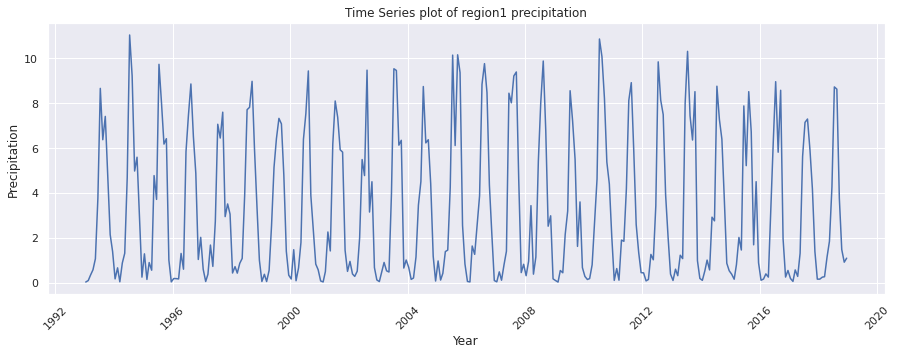

In [75]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,r1_precip, 'b') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of region1 precipitation')
plt.show()

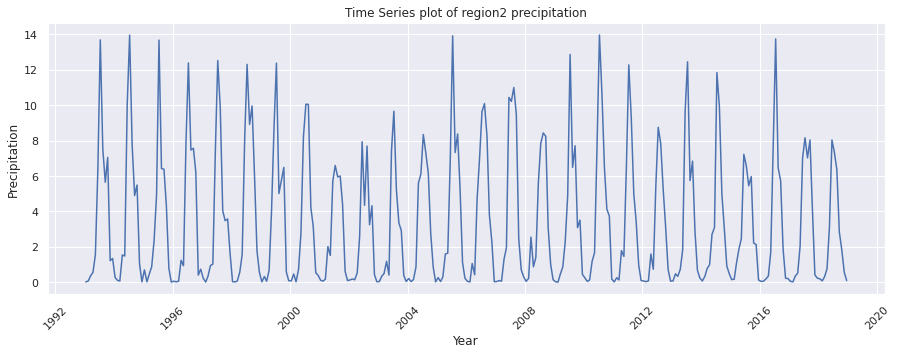

In [76]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,r2_precip, 'b') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of region2 precipitation')
plt.show()

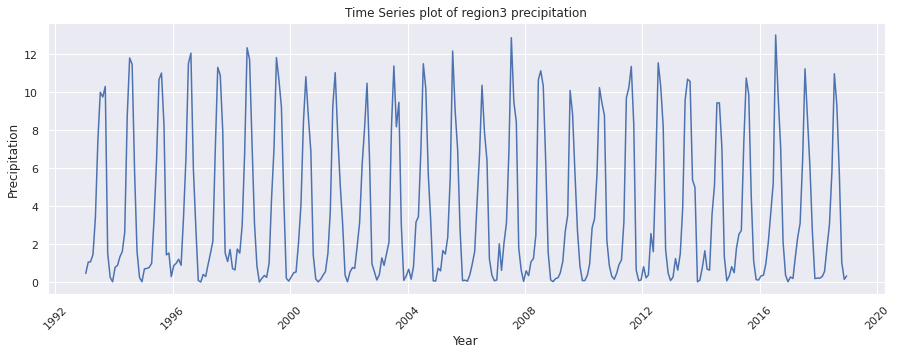

In [77]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,r3_precip, 'b') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of region3 precipitation')
plt.show()

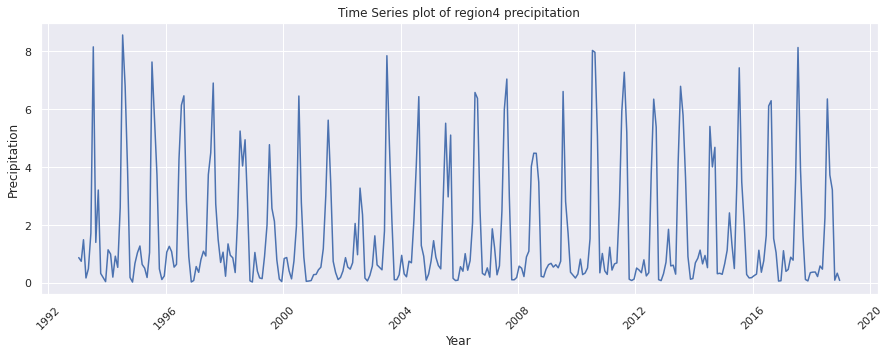

In [78]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,r4_precip, 'b') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of region4 precipitation')
plt.show()

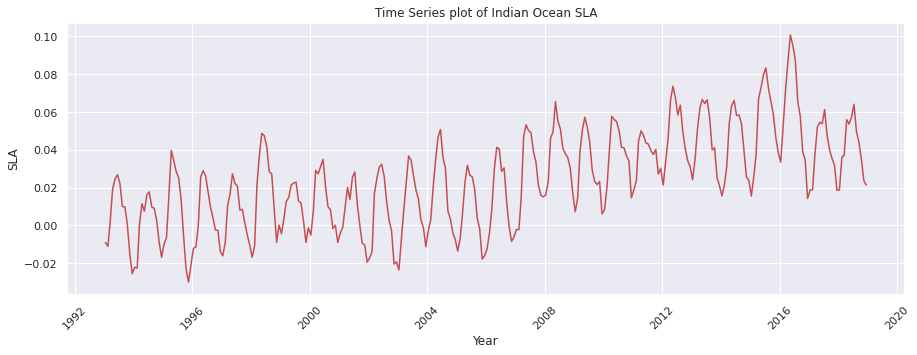

In [79]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,s1, 'r') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('SLA')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of Indian Ocean SLA')
plt.show()

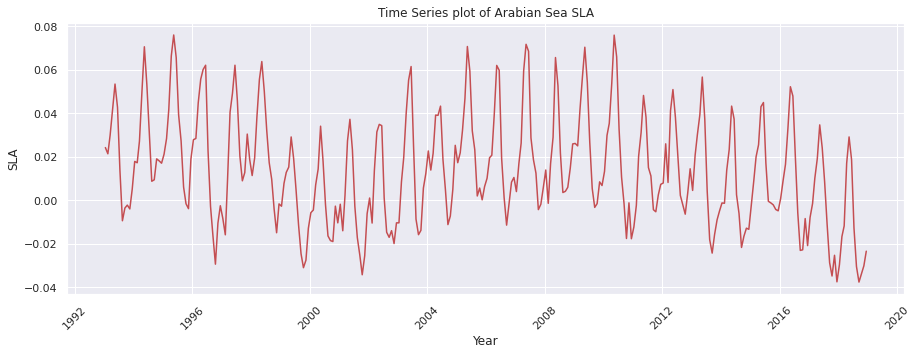

In [80]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,s2, 'r') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('SLA')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of Arabian Sea SLA')
plt.show()

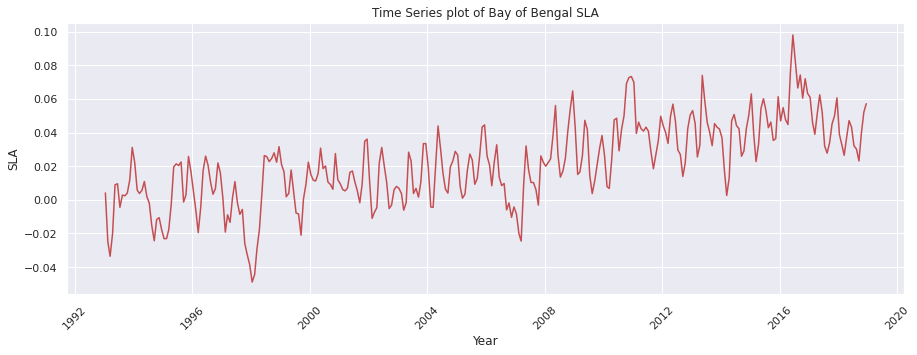

In [81]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,s3, 'r') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('SLA')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of Bay of Bengal SLA')
plt.show()

In [82]:
# ONI ENSO INDEX

col = np.arange(13)
data = pd.DataFrame(np.loadtxt("/media/rghoshal/D4A6E10AA6E0EE441/UGP/datasets/oni.txt"),columns=col).set_index(0).stack()
data = pd.DataFrame(data).rename(columns = {0:"oni"})
data = data.reset_index().rename(columns = {0:"year","level_1":"month"})
data = data[data["year"] != 2020]
# data

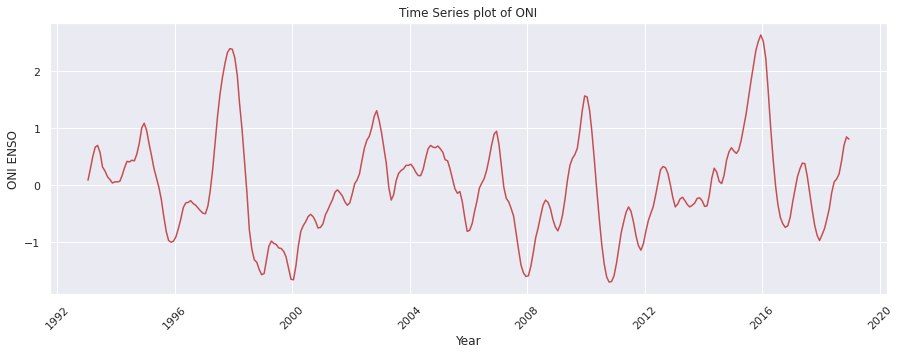

In [83]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(time,data['oni'][(data["year"] > 1992) & (data["year"] < 2019)], 'r') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('ONI ENSO')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of ONI')
plt.show()

In [84]:
import random
from dateutil.parser import parse
from scipy import signal
from scipy.interpolate import interp1d
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.var_model import VAR

In [85]:
df = pd.DataFrame({"precip_SE":np.array(r1_precip),
                   "precip_SW":np.array(r2_precip),
                   "precip_NE":np.array(r3_precip),
                   "precip_NW":np.array(r4_precip),
                   "sla_io":np.array(s1),
                   "sla_as":np.array(s2),
                   "sla_bb":np.array(s3),
                   "enso":np.array(data['oni'][(data["year"] > 1992) & (data["year"] < 2019)])})

In [86]:
df.set_index(time,inplace=True)

In [87]:
stat,p = stats.normaltest(df.precip_NW)
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

Statistics = 83.171, p=0.000
Data looks non-Gaussian (reject null hypothesis)


count    312.000000
mean       3.256447
std        3.204067
min        0.019369
25%        0.516317
50%        1.813522
75%        5.932414
max       11.046390
Name: precip_SE, dtype: float64

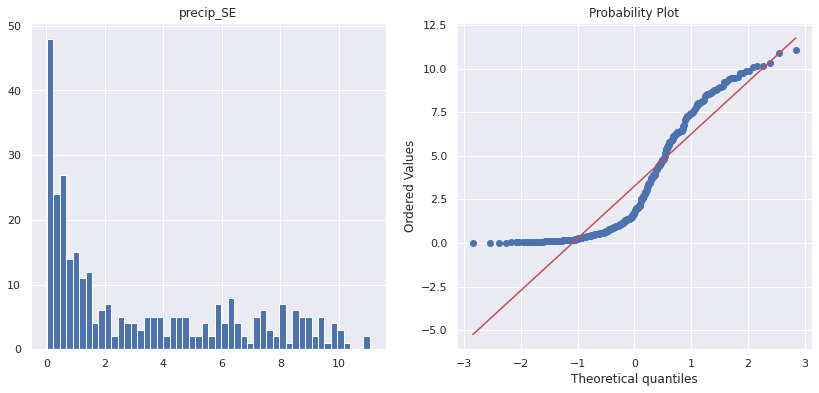

In [88]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['precip_SE'].hist(bins=50)
plt.title('precip_SE')
plt.subplot(1,2,2)
stats.probplot(df['precip_SE'], plot=plt);
df.precip_SE.describe().T

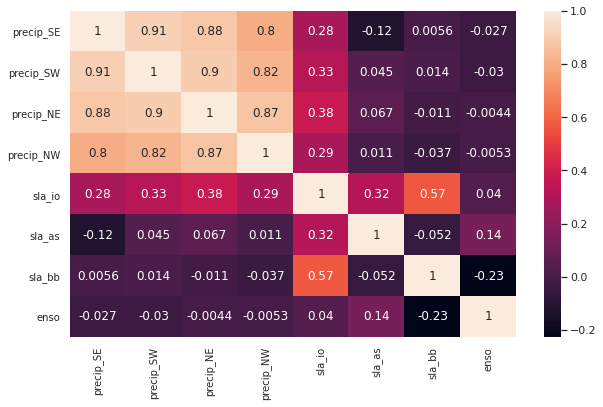

In [89]:
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,annot = True,annot_kws={'size':12})
heatmap = plt.gcf()
heatmap.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

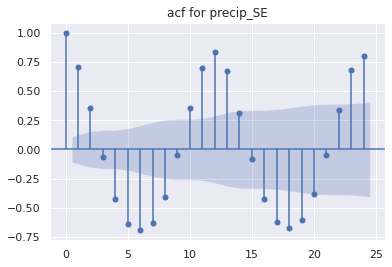

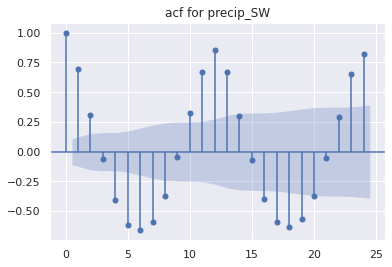

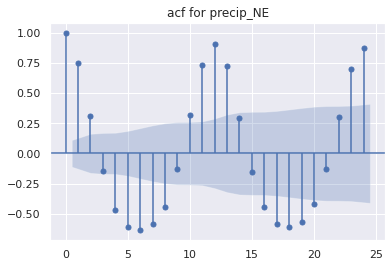

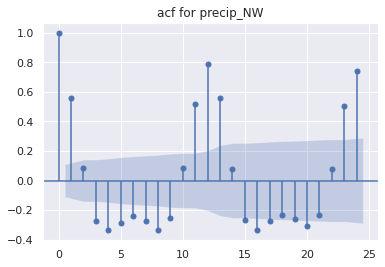

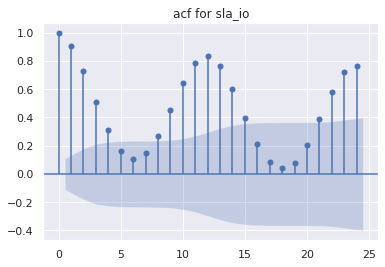

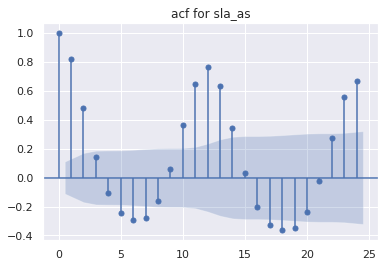

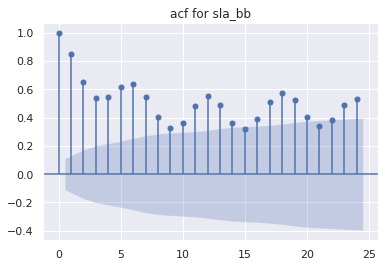

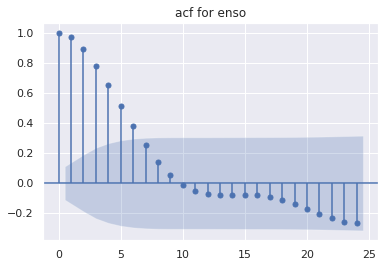

In [90]:
for i in df:
    plot_acf(df[i],lags=24)
    plt.title("acf for "+i )
    plt.show()

In [92]:
n_obs=12
X_train, X_test = df[0:-n_obs], df[-n_obs:]
print(X_train.shape, X_test.shape)
X_train.head()

(300, 8) (12, 8)


,precip_SE,precip_SW,precip_NE,precip_NW,sla_io,sla_as,sla_bb,enso
1993-01-15,0.021624,0.017512,0.470287,0.871136,-0.009085,0.024191,0.004093,0.09
1993-02-15,0.086838,0.065322,1.064722,0.744893,-0.011084,0.021336,-0.025071,0.30
1993-03-15,0.326017,0.348154,1.076788,1.490146,0.001415,0.029823,-0.033581,0.50
1993-04-15,0.568632,0.559666,1.463752,0.168161,0.019108,0.041734,-0.019801,0.67
1993-05-15,1.059878,1.558768,3.400373,0.487609,0.024512,0.053349,0.008861,0.70


In [109]:
transform_data = X_train.iloc[:,0:4].groupby(X_train.index.month).transform(lambda x: (x - x.mean()) / x.std())
transform_data[X_train.columns[4:7]] = X_train.iloc[:,4:7].diff()
transform_data[X_train.columns[7]] = X_train.iloc[:,7]
transform_data.dropna(inplace=True)

In [110]:
transform_data.describe()

,precip_SE,precip_SW,precip_NE,precip_NW,sla_io,sla_as,sla_bb,enso
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,0.002810,0.002356,-0.000060,-0.002459,0.000092,-0.000206,0.000189,-0.021773
std,0.981869,0.982228,0.983078,0.982152,0.010827,0.015043,0.013010,0.876644
min,-2.304445,-2.389524,-2.744399,-2.942390,-0.022769,-0.040295,-0.030395,-1.700000
25%,-0.681141,-0.634797,-0.690427,-0.638691,-0.007726,-0.011851,-0.009135,-0.590000
50%,-0.232919,-0.265234,-0.166901,-0.216508,-0.001306,0.001928,-0.000369,-0.120000
75%,0.539651,0.542675,0.601196,0.641454,0.007116,0.010440,0.009156,0.445000
max,4.076749,4.037767,4.572539,3.751834,0.032830,0.036598,0.041504,2.640000


In [111]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
print('Augmented Dickey-Fuller Test: Precipitation SE Time Series')
augmented_dickey_fuller_statistics(transform_data['precip_SE'])
print('Augmented Dickey-Fuller Test: Precipitation NW Time Series')
augmented_dickey_fuller_statistics(transform_data['precip_NW'])
print('Augmented Dickey-Fuller Test: Precipitation SW Time Series')
augmented_dickey_fuller_statistics(transform_data['precip_SW'])
print('Augmented Dickey-Fuller Test: Precipitation NE Time Series')
augmented_dickey_fuller_statistics(transform_data['precip_NE'])
print('Augmented Dickey-Fuller Test: SLA Indian Ocean Time Series')
augmented_dickey_fuller_statistics(transform_data['sla_io'])
print('Augmented Dickey-Fuller Test: SLA Bay of bengal Time Series')
augmented_dickey_fuller_statistics(transform_data['sla_bb'])
print('Augmented Dickey-Fuller Test: SLA Arabian sea Time Series')
augmented_dickey_fuller_statistics(transform_data['sla_as'])
print('Augmented Dickey-Fuller Test: ENSO Time Series')
augmented_dickey_fuller_statistics(transform_data['enso'])

Augmented Dickey-Fuller Test: Precipitation SE Time Series
ADF Statistic: -18.292065
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Augmented Dickey-Fuller Test: Precipitation NW Time Series
ADF Statistic: -15.223569
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Augmented Dickey-Fuller Test: Precipitation SW Time Series
ADF Statistic: -16.976848
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Augmented Dickey-Fuller Test: Precipitation NE Time Series
ADF Statistic: -16.280080
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Augmented Dickey-Fuller Test: SLA Indian Ocean Time Series
ADF Statistic: -4.940129
p-value: 0.000029
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: SLA Bay of bengal Time Series
ADF Statistic: -7.314309
p-value: 0.000000
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: SLA Arabian sea Time Series
A

In [112]:
print('Augmented Dickey-Fuller Test: Precipitation SE Time Series')
augmented_dickey_fuller_statistics(X_train['precip_SE'])
print('Augmented Dickey-Fuller Test: Precipitation NW Time Series')
augmented_dickey_fuller_statistics(X_train['precip_NW'])
print('Augmented Dickey-Fuller Test: Precipitation SW Time Series')
augmented_dickey_fuller_statistics(X_train['precip_SW'])
print('Augmented Dickey-Fuller Test: Precipitation NE Time Series')
augmented_dickey_fuller_statistics(X_train['precip_NE'])
print('Augmented Dickey-Fuller Test: SLA Indian Ocean Time Series')
augmented_dickey_fuller_statistics(X_train['sla_io'])
print('Augmented Dickey-Fuller Test: SLA Bay of bengal Time Series')
augmented_dickey_fuller_statistics(X_train['sla_bb'])
print('Augmented Dickey-Fuller Test: SLA Arabian sea Time Series')
augmented_dickey_fuller_statistics(X_train['sla_as'])
print('Augmented Dickey-Fuller Test: ENSO Time Series')
augmented_dickey_fuller_statistics(X_train['enso'])

Augmented Dickey-Fuller Test: Precipitation SE Time Series
ADF Statistic: -4.497412
p-value: 0.000199
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: Precipitation NW Time Series
ADF Statistic: -3.180514
p-value: 0.021141
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: Precipitation SW Time Series
ADF Statistic: -2.536818
p-value: 0.106771
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: Precipitation NE Time Series
ADF Statistic: -3.892189
p-value: 0.002093
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: SLA Indian Ocean Time Series
ADF Statistic: -1.837767
p-value: 0.361879
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: SLA Bay of bengal Time Series
ADF Statistic: -1.173020
p-value: 0.685093
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: SLA Arabian sea Time Series
ADF S

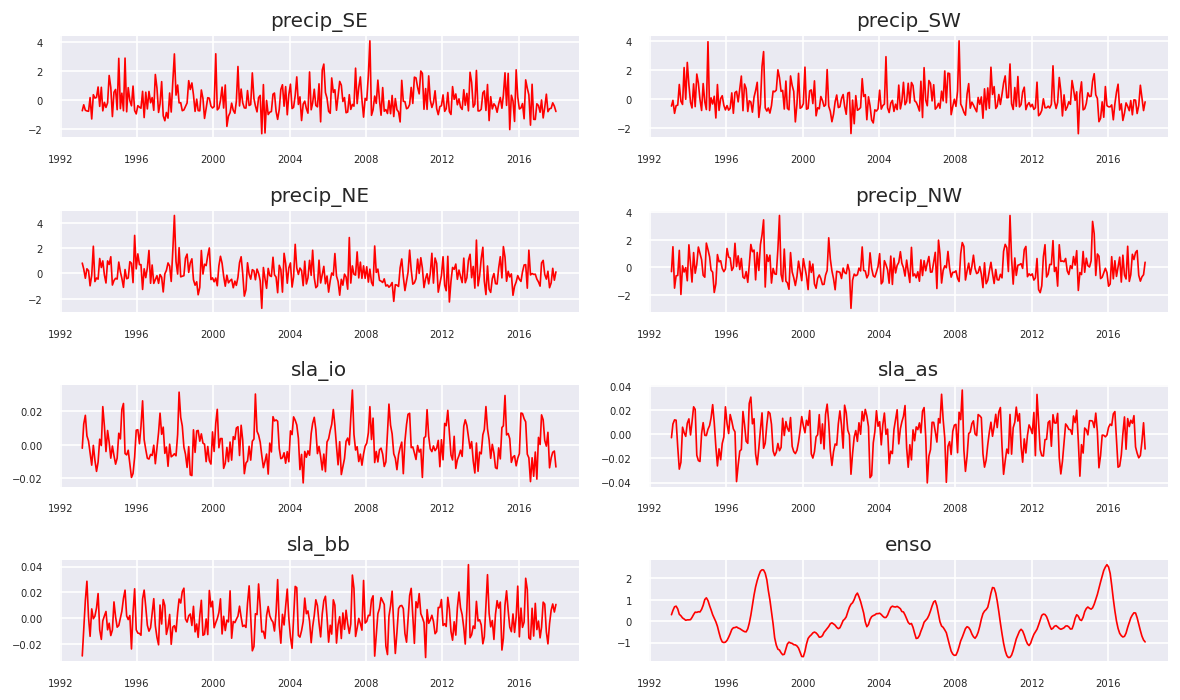

In [113]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    d = transform_data[transform_data.columns[i]]
    ax.plot(d, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

In [114]:
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset
grangers_causality_matrix(transform_data, variables = transform_data.columns)

,precip_SE_x,precip_SW_x,precip_NE_x,precip_NW_x,sla_io_x,sla_as_x,sla_bb_x,enso_x
precip_SE_y,1.0000,0.1166,0.2977,0.0202,0.3819,0.2647,0.5899,0.1309
precip_SW_y,0.0125,1.0000,0.4705,0.5291,0.3499,0.3926,0.4715,0.0483
precip_NE_y,0.0138,0.0357,1.0000,0.0790,0.6488,0.4176,0.7907,0.0243
precip_NW_y,0.2014,0.0367,0.0657,1.0000,0.4285,0.8712,0.8911,0.5991
sla_io_y,0.1073,0.2261,0.4154,0.1651,1.0000,0.0000,0.0000,0.1036
sla_as_y,0.0475,0.0390,0.2847,0.0865,0.0000,1.0000,0.0000,0.0000
sla_bb_y,0.0791,0.3155,0.1098,0.7215,0.0000,0.0000,1.0000,0.0000
enso_y,0.1232,0.4767,0.0157,0.5911,0.4967,0.0563,0.0046,1.0000


In [115]:
import statsmodels
# transform_data.index = pd.DatetimeIndex(transform_data.index).to_period('M')
mod = VAR(transform_data)
res = mod.select_order(maxlags=5)
res.summary()
# for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
#     result = mod.fit(i)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')

/home/rghoshal/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,-28.01,-27.91,6.872e-13,-27.97
1,-31.28,-30.38,2.602e-14,-30.92
2,-32.98,-31.28*,4.753e-15,-32.30
3,-33.55,-31.05,2.694e-15,-32.55*
4,-33.86,-30.55,1.991e-15,-32.53
5,-33.90*,-29.79,1.918e-15*,-32.26


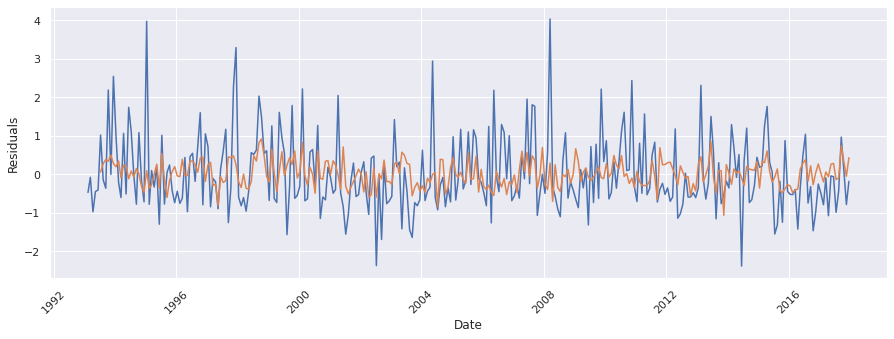

In [123]:
res = mod.fit(5)
y_fitted = res.fittedvalues
plt.figure(figsize = (15,5))
plt.plot(transform_data.precip_SW, label='resid')
plt.plot(y_fitted.precip_SW, label='VAR prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Residuals')
plt.grid(True)

In [124]:
from statsmodels.stats import stattools
stattools.durbin_watson(res.resid)

array([1.98775463, 1.95987203, 1.9697555 , 2.00012307, 2.15086643,
       2.1463316 , 1.98461339, 1.85474514])

In [125]:
# Get the lag order
lag_order = res.k_ar
print(lag_order)
# Input data for forecasting
input_data = transform_data.values[-lag_order:]
# print(input_data)
# forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index[-n_obs:], columns=X_test.columns + '_pred'))
pred

5


,precip_SE_pred,precip_SW_pred,precip_NE_pred,precip_NW_pred,sla_io_pred,sla_as_pred,sla_bb_pred,enso_pred
2018-01-15,0.903266,0.993157,0.509645,0.202950,-0.001795,0.004648,-0.001785,-1.015163
2018-02-15,-0.205358,-0.225029,0.037068,-0.451333,-0.001463,-0.001472,-0.013196,-0.997941
2018-03-15,-0.168071,-0.006610,-0.147102,0.164047,0.005548,0.004886,-0.002595,-0.948912
2018-04-15,0.317355,0.441859,0.387688,0.245125,0.009448,0.014244,0.002825,-0.857299
2018-05-15,0.029470,0.053758,0.068582,-0.039604,0.008572,0.010655,0.003016,-0.744016
2018-06-15,-0.025128,-0.068823,-0.323015,-0.120103,0.003038,0.001254,0.002963,-0.623151
2018-07-15,0.006218,0.051949,-0.046394,-0.020939,0.001442,-0.005021,-0.001302,-0.510480
2018-08-15,-0.029866,0.070390,-0.110243,-0.018542,-0.000884,-0.010732,-0.006850,-0.401220
2018-09-15,-0.065056,-0.021788,-0.170419,-0.087225,-0.003102,-0.008815,-0.003549,-0.288505
2018-10-15,-0.037507,-0.008480,-0.126231,-0.070733,-0.005100,-0.004332,0.000650,-0.171649


In [134]:
# inverting transformation
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        
        forecast[str(col)+'_pred'] = X_train[str(col)].mean() + X_train[str(col)].std()*forecast[str(col)+'_pred'].cumsum()
    return forecast

output = invert_transformation(X_train, pred)
#combining predicted and real data set
combine = pd.concat([output['precip_SE_pred'], X_test['precip_SE']], axis=1)
combine = combine.reset_index()
# combine = combine.sort_values(by='Date', ascending=False)

In [135]:
combine

,index,precip_SE_pred,precip_SE
0,2018-01-15,6.179791,0.150850
1,2018-02-15,5.520173,0.238964
2,2018-03-15,4.980322,0.258986
3,2018-04-15,5.999679,1.132848
4,2018-05-15,6.094340,1.841481
5,2018-06-15,6.013627,4.266157
6,2018-07-15,6.033600,8.728517
7,2018-08-15,5.937667,8.629925
8,2018-09-15,5.728706,3.759714
9,2018-10-15,5.608232,1.470953
